In [ ]:
##denpendents 
import os
import shutil
import random

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras

<h2 style='text-align:center; font-family:Geogeria; color:white'><b>Splitting Raw Data</b></h2>

In [2]:
##folder structures and directory
RAW_DIR = "data/raw"
OUT_DIR = "data"

##splitting ratio
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

##Reproducibility
SEED = 42
random.seed(SEED)

##Identify class labels
folder_name_list=os.listdir(RAW_DIR)

##Folder names become class labels
##keeps only folders ["apple", "mango", "grapes", "potato"]
classes = [cls for cls in folder_name_list if os.path.isdir(os.path.join(RAW_DIR, cls))] 

# Create directory structure
##Create output directory structure
##Iterates over dataset splits
for split in ["train", "val", "test"]:
    ##Iterates over class labels
    for clss in classes:
        os.makedirs(os.path.join(OUT_DIR, split, clss), exist_ok=True) #Creates directories

# Split per class
#Process one class at a time
#This ensures class-wise stratification
for cls in classes:
    #full path to one class folder like data/raw/apple
    cls_path = os.path.join(RAW_DIR, cls)
    ##list of images within list of folder 
    img_list=os.listdir(cls_path)
    #Collects only image files
    images = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]

    ##image suffling
    random.shuffle(images)

    #Compute split sizes
    n_total = len(images)
    n_train = int(TRAIN_RATIO * n_total)
    n_val = int(VAL_RATIO * n_total)

    train_imgs = images[:n_train]
    val_imgs = images[n_train:n_train + n_val]
    test_imgs = images[n_train + n_val:]

    #Copy images into split folders
    for img in train_imgs:
        shutil.copy(
            os.path.join(cls_path, img),
            os.path.join(OUT_DIR, "train", cls, img)
        )

    for img in val_imgs:
        shutil.copy(
            os.path.join(cls_path, img),
            os.path.join(OUT_DIR, "val", cls, img)
        )

    for img in test_imgs:
        shutil.copy(
            os.path.join(cls_path, img),
            os.path.join(OUT_DIR, "test", cls, img)
        )

print("Train / Validation / Test split completed.")

Train / Validation / Test split completed.


In [3]:
classes

['Cashew healthy',
 'Cashew anthracnose',
 'Cashew red rust',
 'Cassava mosaic',
 'Cashew leaf miner',
 'Cashew gumosis',
 'Maize leaf beetle',
 'Maize fall armyworm',
 'Cassava bacterial blight',
 'Cassava brown spot',
 'Cassava healthy',
 'Maize healthy',
 'Maize grasshoper',
 'Tomato leaf blight',
 'Maize leaf blight',
 'Maize streak virus',
 'Tomato verticulium wilt',
 'Maize leaf spot',
 'Tomato leaf curl',
 'Cassava green mite',
 'Tomato healthy',
 'Tomato septoria leaf spot']

<h2 style='text-align:center; font-family:Geogeria; color:white'><b>Data Preprocessing: Converting images into an Array</b></h2>

In [ ]:
##data directories
TRAIN_DIR='data/train'
TEST_DIR='data/test'
VAL_DIR='data/val'

##image process
IMG_HIGHT=180    ##Resize all images
IMG_WIDTH=180   ##Resize all images
BATCH_SIZE=32   

# Loads images from directories, automatically assigns labels from folder names
##output dataset format look like this (images,labels) in memory
train_ds = tf.keras.utils.image_dataset_from_directory( 
    TRAIN_DIR,
    image_size=(IMG_HIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,       # Shuffle training dataset
    seed=42,
    validation_split=False
)

##validation data preprocess
val_ds = tf.keras.utils.image_dataset_from_directory( 
    VAL_DIR,
    image_size=(IMG_HIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,       #shuffle is not needed for validation/test
    validation_split=False
)

##test data preprocess
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_HIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,    #shuffle is not needed for validation/test
    validation_split=False
)

Found 17645 files belonging to 22 classes.
Found 3771 files belonging to 22 classes.
Found 3804 files belonging to 22 classes.


In [10]:
##disease class
dis_class=train_ds.class_names

<h2 style='text-align:center; font-family:Geogeria; color:white'><b>Display Images</b></h2>

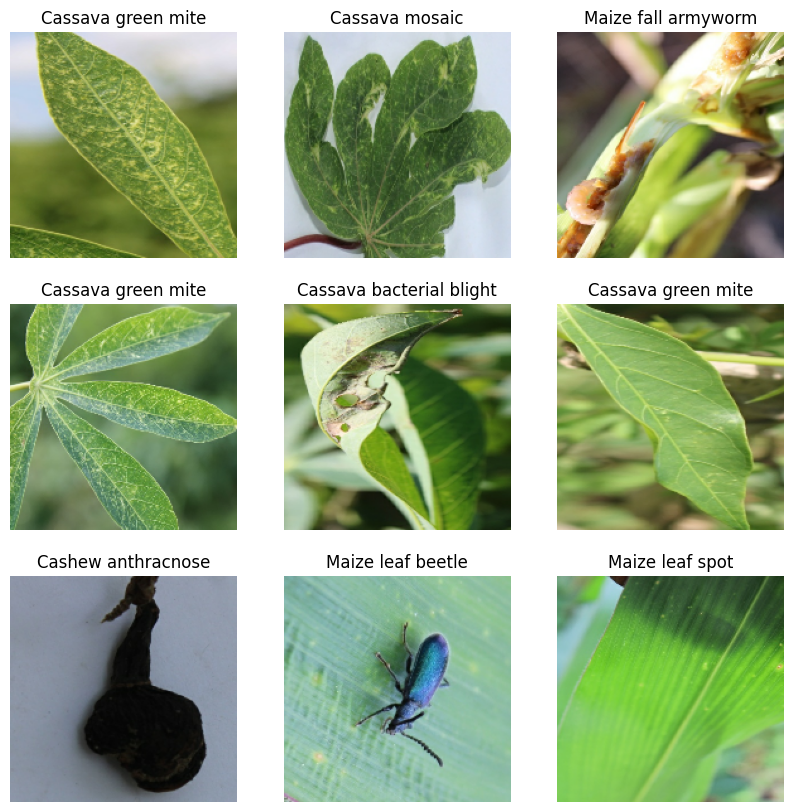

In [17]:
##print images from the train dataset
## taking 1st batch only take(1)

plt.figure(figsize=(10,10))
for image,labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(np.array(image[i]).astype('uint8'))
        plt.title(dis_class[labels[i]])
        plt.axis("off")
plt.show()